In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

## print out the names of the first 5 image_files (total = 10 images for train_imgaes & train_label_masks) with the train, test, submission.csv files
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:5]:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/prostate-cancer-grade-assessment/train.csv
/kaggle/input/prostate-cancer-grade-assessment/test.csv
/kaggle/input/prostate-cancer-grade-assessment/sample_submission.csv
/kaggle/input/prostate-cancer-grade-assessment/train_label_masks/4b223c776c0ddb0699d74f3334c1e5e6_mask.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_label_masks/b481b56617ce096435cb591adc6dd0b9_mask.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_label_masks/53dfff0cecd06c15f600d334e7324b78_mask.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_label_masks/eb846d2f14749c4913bf0affa0578d8d_mask.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_label_masks/f526a2ca5612d5913984a67edabaf991_mask.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_images/0cc35bc0fe4dd912b20f72d66888fd49.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_images/4f53892473ee239f9dc9d80047cb3627.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_images/9335fbc722c3feb51e73c1

In [2]:
import os

# There are two ways to load the data from the PANDA dataset:
# Option 1: Load images using openslide
import openslide
# Option 2: Load images using skimage (requires that tifffile is installed)
import skimage.io
import random
import seaborn as sns
import cv2

# General packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import PIL
from IPython.display import Image, display

# Plotly for the interactive viewer (see last section)
import plotly.graph_objs as go

In [3]:
# Location of the training images

BASE_PATH = '../input/prostate-cancer-grade-assessment'

# image and mask directories
data_dir = f'{BASE_PATH}/train_images'
mask_dir = f'{BASE_PATH}/train_label_masks'


# Location of training labels
train = pd.read_csv(f'{BASE_PATH}/train.csv').set_index('image_id')
test = pd.read_csv(f'{BASE_PATH}/test.csv')

train_labels = pd.read_csv('/kaggle/input/prostate-cancer-grade-assessment/train.csv').set_index('image_id')

submission = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')

In [4]:
train.head()

data_provider  isup_grade gleason_score
image_id                                                                
0005f7aaab2800f6170c399693a96917    karolinska           0           0+0
000920ad0b612851f8e01bcc880d9b3d    karolinska           0           0+0
0018ae58b01bdadc8e347995b69f99aa       radboud           4           4+4
001c62abd11fa4b57bf7a6c603a11bb9    karolinska           4           4+4
001d865e65ef5d2579c190a0e0350d8f    karolinska           0           0+0

In [5]:
print("Shape of training data :", train.shape)
print("Mainly information of training data :", train.info())
print("unique data provider :", len(train.data_provider.unique()))
print("unique isup_grade(target) :", len(train.isup_grade.unique()))
print("unique gleason_score :", len(train.gleason_score.unique()))

Shape of training data : (10616, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 10616 entries, 0005f7aaab2800f6170c399693a96917 to ffe9bcababc858e04840669e788065a1
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   data_provider  10616 non-null  object
 1   isup_grade     10616 non-null  int64 
 2   gleason_score  10616 non-null  object
dtypes: int64(1), object(2)
memory usage: 331.8+ KB
Mainly information of training data : None
unique data provider : 2
unique isup_grade(target) : 6
unique gleason_score : 11


In [6]:
submission.head()

image_id  isup_grade
0  005700be7e06878e6605e7a5a39de1b2           0
1  005c6e8877caf724c600fdce5d417d40           0
2  0104f76634ff89bfff1ef0804a95c380           0

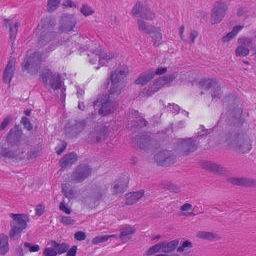

In [7]:
# Open the image (does not yet read the image into memory)
path = os.path.join(data_dir, '005e66f06bce9c2e49142536caf2f6ee.tiff')
image = openslide.OpenSlide(path)

# Read a specific region of the image starting at upper left coordinate (x=17800, y=19500) on level 0 and extracting a 256*256 pixel patch.
# At this point image data is read from the file and loaded into memory.
patch = image.read_region((17800,19500), 0, (256, 256))

# Display the image
display(patch)

# Close the opened slide after use
image.close()

In [8]:
help(openslide.OpenSlide)

Help on class OpenSlide in module openslide:

class OpenSlide(AbstractSlide)
 |  OpenSlide(filename)
 |  
 |  An open whole-slide image.
 |  
 |  close() is called automatically when the object is deleted.
 |  The object may be used as a context manager, in which case it will be
 |  closed upon exiting the context.
 |  
 |  If an operation fails, OpenSlideError is raised.  Note that OpenSlide
 |  has latching error semantics: once OpenSlideError is raised, all future
 |  operations on the OpenSlide object, other than close(), will fail.
 |  
 |  Method resolution order:
 |      OpenSlide
 |      AbstractSlide
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, filename)
 |      Open a whole-slide image.
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  close(self)
 |      Close the OpenSlide object.
 |  
 |  get_best_level_for_downsample(self, downsample)
 |      Return the best level for displaying the given downsample.
 |  
 |  read_region(self, l

In [9]:
image.get_best_level_for_downsample
#biopsy.get_best_level_for_downsample

<bound method OpenSlide.get_best_level_for_downsample of OpenSlide('../input/prostate-cancer-grade-assessment/train_images/005e66f06bce9c2e49142536caf2f6ee.tiff')>

In [10]:
## loading a slide
biopsy = openslide.OpenSlide(path)
# do someting with the slide here
biopsy.close()

In [11]:
def print_slide_details(slide, show_thumbnail=True, max_size=(600,400)):
    """Print some basic information about a slide"""
    # Generate a small image thumbnail
    if show_thumbnail:
        display(slide.get_thumbnail(size=max_size))

    # Here we compute the "pixel spacing": the physical size of a pixel in the image.
    # OpenSlide gives the resolution in centimeters so we convert this to microns.
    spacing = 1 / (float(slide.properties['tiff.XResolution']) / 10000)
    
    print(f"File id: {slide}")
    print(f"Dimensions: {slide.dimensions}")
    print(f"Microns per pixel / pixel spacing: {spacing:.3f}")
    print(f"Number of levels in the image: {slide.level_count}")
    print(f"Downsample factor per level: {slide.level_downsamples}")
    print(f"Dimensions of levels: {slide.level_dimensions}")

**What does `slide.level_downsamples & .level_dimensions` mean?**

In [12]:
biopsy = openslide.OpenSlide(path)
help(biopsy.level_count)

Help on int object:

class int(object)
 |  int([x]) -> integer
 |  int(x, base=10) -> integer
 |  
 |  Convert a number or string to an integer, or return 0 if no arguments
 |  are given.  If x is a number, return x.__int__().  For floating point
 |  numbers, this truncates towards zero.
 |  
 |  If x is not a number or if base is given, then x must be a string,
 |  bytes, or bytearray instance representing an integer literal in the
 |  given base.  The literal can be preceded by '+' or '-' and be surrounded
 |  by whitespace.  The base defaults to 10.  Valid bases are 0 and 2-36.
 |  Base 0 means to interpret the base from the string as an integer literal.
 |  >>> int('0b100', base=0)
 |  4
 |  
 |  Methods defined here:
 |  
 |  __abs__(self, /)
 |      abs(self)
 |  
 |  __add__(self, value, /)
 |      Return self+value.
 |  
 |  __and__(self, value, /)
 |      Return self&value.
 |  
 |  __bool__(self, /)
 |      self != 0
 |  
 |  __ceil__(...)
 |      Ceiling of an Integral retur

In [13]:
help(biopsy.level_downsamples)

Help on tuple object:

class tuple(object)
 |  tuple(iterable=(), /)
 |  
 |  Built-in immutable sequence.
 |  
 |  If no argument is given, the constructor returns an empty tuple.
 |  If iterable is specified the tuple is initialized from iterable's items.
 |  
 |  If the argument is a tuple, the return value is the same object.
 |  
 |  Methods defined here:
 |  
 |  __add__(self, value, /)
 |      Return self+value.
 |  
 |  __contains__(self, key, /)
 |      Return key in self.
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(self, key, /)
 |      Return self[key].
 |  
 |  __getnewargs__(self, /)
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __hash__(self, /)
 |      Return hash(self).
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __le__(self, value, /)
 |      Return self<

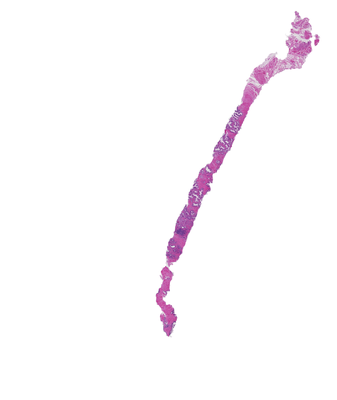

File id: OpenSlide('../input/prostate-cancer-grade-assessment/train_images/005e66f06bce9c2e49142536caf2f6ee.tiff')
Dimensions: (31744, 37632)
Microns per pixel / pixel spacing: 0.452
Number of levels in the image: 3
Downsample factor per level: (1.0, 4.0, 16.0)
Dimensions of levels: ((31744, 37632), (7936, 9408), (1984, 2352))
ISUP grade: 1
Gleason score: 3+3




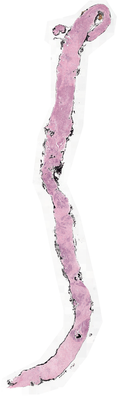

File id: OpenSlide('../input/prostate-cancer-grade-assessment/train_images/00928370e2dfeb8a507667ef1d4efcbb.tiff')
Dimensions: (10752, 36352)
Microns per pixel / pixel spacing: 0.486
Number of levels in the image: 3
Downsample factor per level: (1.0, 4.0, 16.0)
Dimensions of levels: ((10752, 36352), (2688, 9088), (672, 2272))
ISUP grade: 5
Gleason score: 4+5




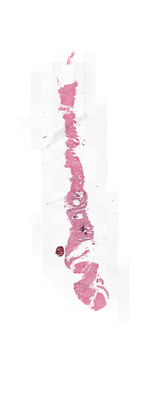

File id: OpenSlide('../input/prostate-cancer-grade-assessment/train_images/007433133235efc27a39f11df6940829.tiff')
Dimensions: (9472, 24320)
Microns per pixel / pixel spacing: 0.486
Number of levels in the image: 3
Downsample factor per level: (1.0, 4.0, 16.0)
Dimensions of levels: ((9472, 24320), (2368, 6080), (592, 1520))
ISUP grade: 0
Gleason score: negative




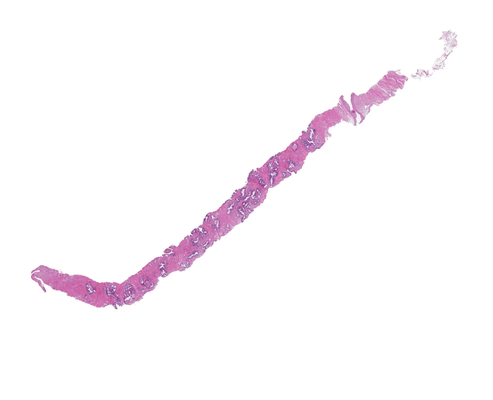

File id: OpenSlide('../input/prostate-cancer-grade-assessment/train_images/024ed1244a6d817358cedaea3783bbde.tiff')
Dimensions: (26891, 21815)
Microns per pixel / pixel spacing: 0.503
Number of levels in the image: 3
Downsample factor per level: (1.0, 4.000498225811406, 16.005841674527478)
Dimensions of levels: ((26891, 21815), (6722, 5453), (1680, 1363))
ISUP grade: 0
Gleason score: 0+0




In [14]:
example_slides = [
    '005e66f06bce9c2e49142536caf2f6ee',
    '00928370e2dfeb8a507667ef1d4efcbb',
    '007433133235efc27a39f11df6940829',
    '024ed1244a6d817358cedaea3783bbde',
]

for case_id in example_slides:
    biopsy = openslide.OpenSlide(os.path.join(data_dir, f'{case_id}.tiff'))
    print_slide_details(biopsy)
    biopsy.close()
    
    # Print the case-level label
    print(f"ISUP grade: {train_labels.loc[case_id, 'isup_grade']}")
    print(f"Gleason score: {train_labels.loc[case_id, 'gleason_score']}\n\n")

**Level 0**

(1.0, 4.0, 16.0)
((10752, 36352), (2688, 9088), (672, 2272))


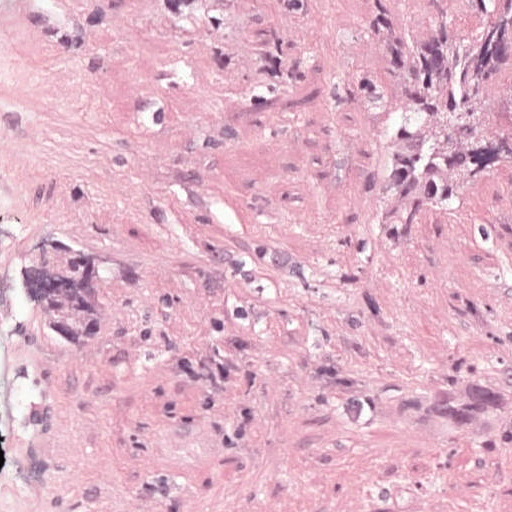

In [15]:
biopsy = openslide.OpenSlide(os.path.join(data_dir, '00928370e2dfeb8a507667ef1d4efcbb.tiff'))
print(biopsy.level_downsamples)
print(biopsy.level_dimensions)
x = 5150
y = 21000
level = 0
width = 512
height = 512

region = biopsy.read_region((x,y), level, (width, height))
display(region)

**Level 2**

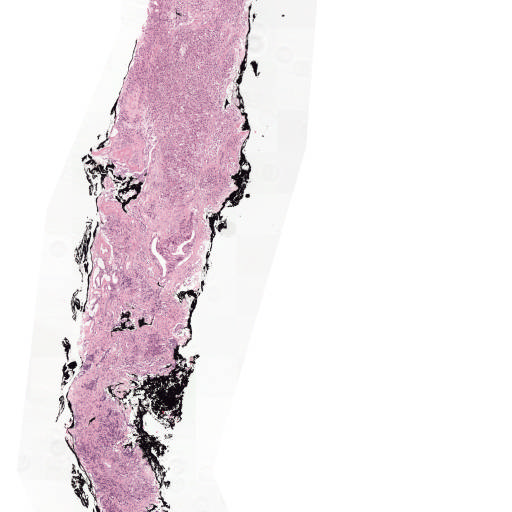

In [16]:
x = 2688
y = 9088
level = 2
width = 512
height = 512
        
region = biopsy.read_region((x,y), level, (width, height))
display(region)

**Level 2 with the `higher starting point`**

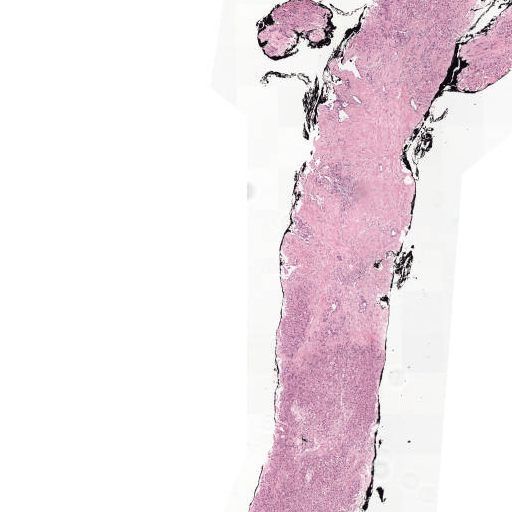

In [17]:
x = 672
y = 2272
level = 2
width = 512
height = 512

region = biopsy.read_region((x,y), level, (width, height))
display(region)

**Using PIL**

To more easily inspect the masks, we map the int labels to `RGB` colors using a color palette. If you prefer something like `matplotlib` you can also use `plt.imshow()` to directly show a mask (without converting it to an `RGB` image).

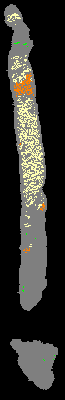

File id: OpenSlide('../input/prostate-cancer-grade-assessment/train_label_masks/08ab45297bfe652cc0397f4b37719ba1_mask.tiff')
Dimensions: (3328, 20224)
Microns per pixel / pixel spacing: 0.480
Number of levels in the image: 3
Downsample factor per level: (1.0, 4.0, 16.0)
Dimensions of levels: ((3328, 20224), (832, 5056), (208, 1264))


In [18]:
# Using PIL
def print_mask_details(slide, center='radboud', show_thumbnail=True, max_size=(400,400)):
    """Print some basic information about a slide"""

    if center not in ['radboud', 'karolinska']:
        raise Exception("Unsupported palette, should be one of [radboud, karolinska].")

    # Generate a small image thumbnail
    if show_thumbnail:
        # Read in the mask data from the highest level
        # We cannot use thumbnail() here because we need to load the raw label data.
        mask_data = slide.read_region((0,0), slide.level_count - 1, slide.level_dimensions[-1])
        # Mask data is present in the R channel
        mask_data = mask_data.split()[0]

        # To show the masks we map the raw label values to RGB values
        preview_palette = np.zeros(shape=768, dtype=int)
        if center == 'radboud':
            # Mapping: {0: background, 1: stroma, 2: benign epithelium, 3: Gleason 3, 4: Gleason 4, 5: Gleason 5}
            preview_palette[0:18] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 0, 1, 0, 1, 1, 0.7, 1, 0.5, 0, 1, 0, 0]) * 255).astype(int)
        elif center == 'karolinska':
            # Mapping: {0: background, 1: benign, 2: cancer}
            preview_palette[0:9] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 1, 0, 0]) * 255).astype(int)
        mask_data.putpalette(data=preview_palette.tolist())
        mask_data = mask_data.convert(mode='RGB')
        mask_data.thumbnail(size=max_size, resample=0)
        display(mask_data)

    # Compute microns per pixel (openslide gives resolution in centimeters)
    spacing = 1 / (float(slide.properties['tiff.XResolution']) / 10000)
    
    print(f"File id: {slide}")
    print(f"Dimensions: {slide.dimensions}")
    print(f"Microns per pixel / pixel spacing: {spacing:.3f}")
    print(f"Number of levels in the image: {slide.level_count}")
    print(f"Downsample factor per level: {slide.level_downsamples}")
    print(f"Dimensions of levels: {slide.level_dimensions}")
    
mask = openslide.OpenSlide(os.path.join(mask_dir, '08ab45297bfe652cc0397f4b37719ba1_mask.tiff'))
print_mask_details(mask, center='radboud')
mask.close()

#### using matplotlib

Given that the masks are just integer matrices, you can also use other packages to display the masks. For example, using matplotlib and a custom color map we can quickly visualize the different cancer regions:

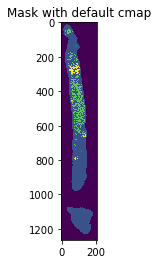

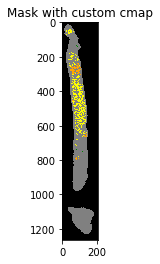

In [19]:
mask = openslide.OpenSlide(os.path.join(mask_dir, '08ab45297bfe652cc0397f4b37719ba1_mask.tiff'))
mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])

plt.figure()
plt.title("Mask with default cmap")
plt.imshow(np.asarray(mask_data)[:,:,0], interpolation='nearest')
plt.show()

plt.figure()
plt.title("Mask with custom cmap")
# Optional: create a custom color map
cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
plt.imshow(np.asarray(mask_data)[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5)
plt.show()


In [20]:
mask = openslide.OpenSlide(os.path.join(mask_dir, '08ab45297bfe652cc0397f4b37719ba1_mask.tiff'))
im = skimage.io.imread(os.path.join(mask_dir, '08ab45297bfe652cc0397f4b37719ba1_mask.tiff'))
im.min(), im.max()

(0, 4)

### overplaying mask on slide

As the masks have the same dimension as the slides, we can overlay the masks on the tissue to directly see which areas are cancerous. This overlay can help you identifying the different growth patterns. To do this, we load both the mask and the biopsy and merge them using `PIL`.

Tip: Want to view the slides in a more interactive way? Using a WSI viewer you can interactively view the slides. Examples of open source viewers that can open the `PANDA` dataset are `ASAP` and `QuPath`. `ASAP` can also overlay the masks on top of the images using the `"Overlay"` functionality. If you use `Qupath`, and the images do not load, try changing the file extension to `.vtif`.

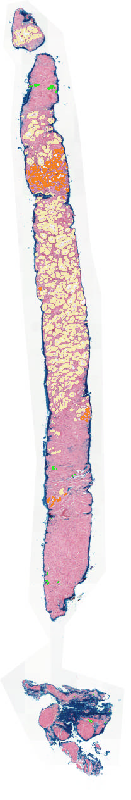

In [21]:
# overplaying mask on slide

def overlay_mask_on_slide(slide, mask, center='radboud', alpha=0.8, max_size=(800, 800)):
    """Show a mask overlayed on a slide."""

    if center not in ['radboud', 'karolinska']:
        raise Exception("Unsupported palette, should be one of [radboud, karolinska].")

    # Load data from the highest level
    slide_data = slide.read_region((0,0), slide.level_count - 1, slide.level_dimensions[-1])
    mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])

    # Mask data is present in the R channel
    mask_data = mask_data.split()[0]

    # Create alpha mask
    alpha_int = int(round(255*alpha))
    if center == 'radboud':
        alpha_content = np.less(mask_data.split()[0], 2).astype('uint8') * alpha_int + (255 - alpha_int)
    elif center == 'karolinska':
        alpha_content = np.less(mask_data.split()[0], 1).astype('uint8') * alpha_int + (255 - alpha_int)
    
    alpha_content = PIL.Image.fromarray(alpha_content)
    preview_palette = np.zeros(shape=768, dtype=int)
    
    if center == 'radboud':
        # Mapping: {0: background, 1: stroma, 2: benign epithelium, 3: Gleason 3, 4: Gleason 4, 5: Gleason 5}
        preview_palette[0:18] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 0, 1, 0, 1, 1, 0.7, 1, 0.5, 0, 1, 0, 0]) * 255).astype(int)
    elif center == 'karolinska':
        # Mapping: {0: background, 1: benign, 2: cancer}
        preview_palette[0:9] = (np.array([0, 0, 0, 0, 1, 0, 1, 0, 0]) * 255).astype(int)
    
    mask_data.putpalette(data=preview_palette.tolist())
    mask_rgb = mask_data.convert(mode='RGB')

    overlayed_image = PIL.Image.composite(image1=slide_data, image2=mask_rgb, mask=alpha_content)
    overlayed_image.thumbnail(size=max_size, resample=0)

    display(overlayed_image)
    
slide = openslide.OpenSlide(os.path.join(data_dir, '08ab45297bfe652cc0397f4b37719ba1.tiff'))
mask = openslide.OpenSlide(os.path.join(mask_dir, '08ab45297bfe652cc0397f4b37719ba1_mask.tiff'))
overlay_mask_on_slide(slide, mask, center='radboud')
slide.close()
mask.close()

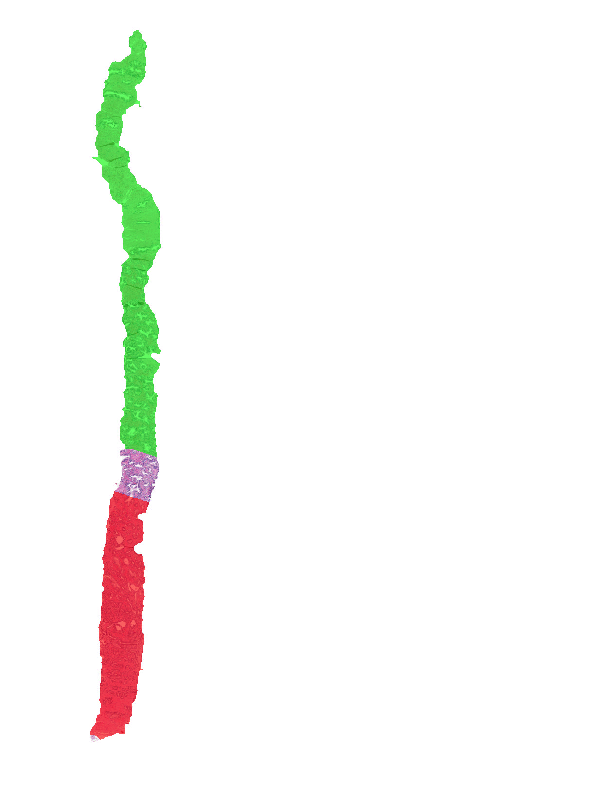

In [22]:
slide = openslide.OpenSlide(os.path.join(data_dir, '090a77c517a7a2caa23e443a77a78bc7.tiff'))
mask = openslide.OpenSlide(os.path.join(mask_dir, '090a77c517a7a2caa23e443a77a78bc7_mask.tiff'))
overlay_mask_on_slide(slide, mask, center='karolinska', alpha=0.6)
slide.close()
mask.close()

**Working on `scikit-image`**

Loading a slide with scikit-image is similar to loading slides with OpenSlide. The major difference between scikit-image and OpenSlide is that scikit-image loads the image into memory. To extract a certain region of the image, you will need to load the whole image at one of the levels.

The images in the PANDA dataset are relatively small because each biopsy was individually extracted from the source slide. The small size makes it possible to load the slides directly into memory. Still, upon loading the image is uncompressed resulting in larger memory usage.

Slides are loaded using the MultiImage class; this class gives the ability to access the individual levels of the image. By default, MultiImage tries to conserve memory usage by only caching the last image level that was accessed.

Biopsy level 0 dimensions: (9728, 20224, 3)
Biopsy level 0 memory size: 562.9mb
Biopsy level 1 dimensions: (2432, 5056, 3)
Biopsy level 1 memory size: 35.2mb
Biopsy level 2 dimensions: (608, 1264, 3)
Biopsy level 2 memory size: 2.2mb


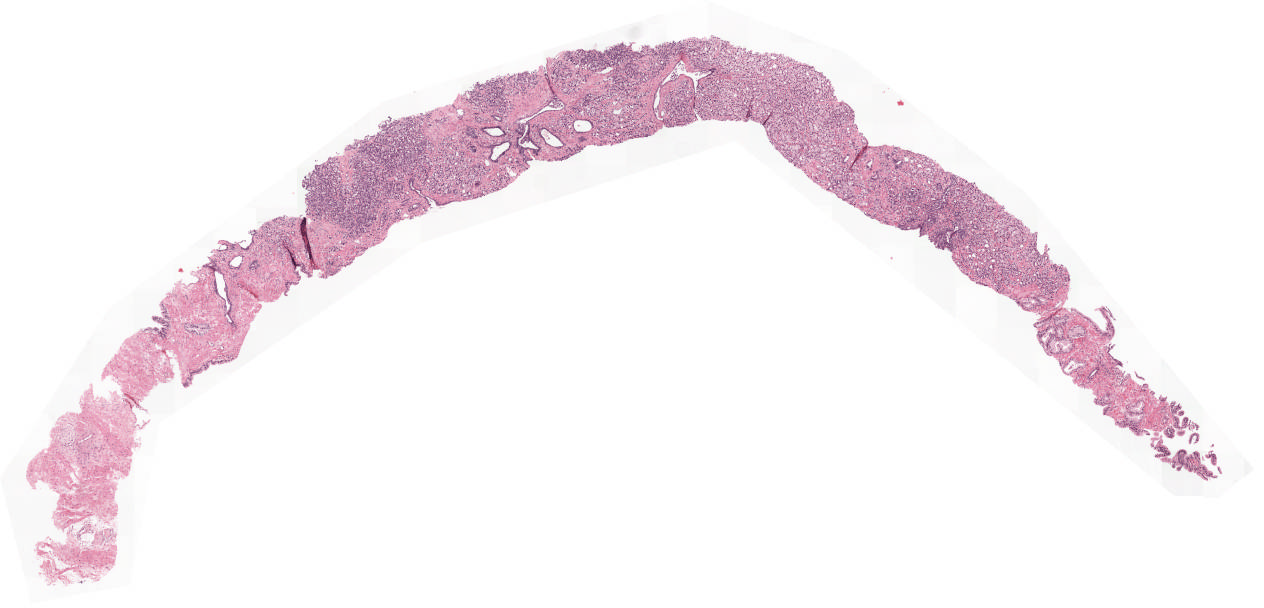

In [23]:
biopsy = skimage.io.MultiImage(os.path.join(data_dir, '0b373388b189bee3ef6e320b841264dd.tiff'))

for i,level in enumerate(biopsy):
    print(f"Biopsy level {i} dimensions: {level.shape}")
    print(f"Biopsy level {i} memory size: {level.nbytes / 1024**2:.1f}mb")
    
display(PIL.Image.fromarray(biopsy[-1]))

In [24]:
biopsy_level_0 = skimage.io.imread(os.path.join(data_dir, '0b373388b189bee3ef6e320b841264dd.tiff'))
print(biopsy_level_0.shape)
print('min_pixel = ', biopsy_level_0.min(), '\t max_pixel = ', biopsy_level_0.max())

(9728, 20224, 3)
min_pixel =  0 	 max_pixel =  255


Similar to OpenSlide, we can extract regions from the whole image by using `scikit-image`. Because the image is already in memory, this boils down to a slice on the numpy array

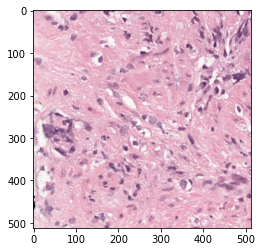

In [25]:
biopsy = skimage.io.MultiImage(os.path.join(data_dir, '00928370e2dfeb8a507667ef1d4efcbb.tiff'))

x = 5150
y = 21000
level = 0
width = 512
height = 512

patch = biopsy[0][y:y+width, x:x+height]

# You can also visualize patches with matplotlib
plt.figure()
plt.imshow(patch)
plt.show()

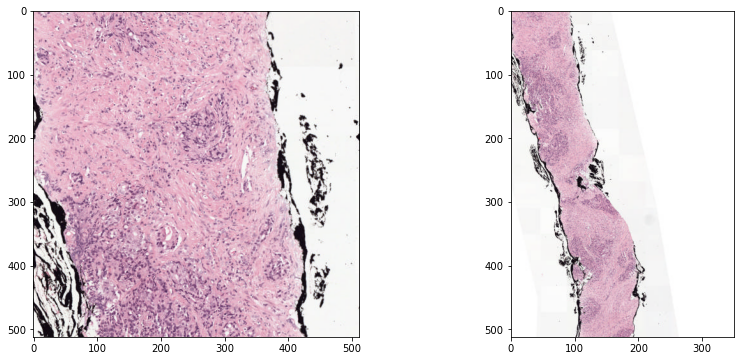

In [26]:
x1 = 5150 // 4
y1 = 21000 // 4
width = 512
height = 512

patch1 = biopsy[1][y1:y1+width, x1:x1+height]

plt.figure(figsize = (14, 6))
plt.subplot(121)
plt.imshow(patch1)

x2 = 5150 // (4*4)
y2 = 21000 // (4*4)
width = 512
height = 512

patch2 = biopsy[2][y2:y2+width, x2:x2+height]
plt.subplot(122)
plt.imshow(patch2)

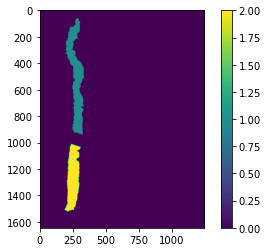

In [27]:
## Loading mask_label

maskfile = skimage.io.MultiImage(os.path.join(mask_dir, '090a77c517a7a2caa23e443a77a78bc7_mask.tiff'))
mask_level_2 = maskfile[-1][:,:,0]

plt.figure()
plt.imshow(mask_level_2)
plt.colorbar()
plt.show()

### Interactive viewer for slides

- Using this viewer you can load any image from the PANDA dataset and interactively zoom in to specific regions. This viewer is a great way of inspecting the data in more detail.

- Want to investigate slides locally on your machine? Using a WSI viewer you can interactively view the slides on your own machine. Examples of open source viewers that can open the PANDA dataset are ASAP and QuPath. ASAP can also overlay the masks on top of the images using the `"Overlay"` functionality. If you use Qupath, and the images do not load, try changing the file extension to `.vtif`

In [28]:
#help(go.FigureWidget)
#help(go.layout.Image)

Help on class FigureWidget in module plotly.graph_objs._figurewidget:

class FigureWidget(plotly.basewidget.BaseFigureWidget)
 |  FigureWidget(*args, **kwargs)
 |  
 |  Base class for FigureWidget. The FigureWidget class is code-generated as a
 |  subclass
 |  
 |  Method resolution order:
 |      FigureWidget
 |      plotly.basewidget.BaseFigureWidget
 |      plotly.basedatatypes.BaseFigure
 |      ipywidgets.widgets.domwidget.DOMWidget
 |      ipywidgets.widgets.widget.Widget
 |      ipywidgets.widgets.widget.LoggingHasTraits
 |      traitlets.traitlets.HasTraits
 |      traitlets.traitlets.HasDescriptors
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data=None, layout=None, frames=None, skip_invalid=False, **kwargs)
 |      Create a new :class:FigureWidget instance
 |      
 |      Parameters
 |      ----------
 |      data
 |          The 'data' property is a tuple of trace instances
 |          that may be specified as:
 |            - A list or tup

In [29]:
class WSIViewer(object):
    def __init__(self, plot_size = 1000):
        self._plot_size = plot_size
        
    def set_slide(self, slide_path):      
        self._slide = openslide.open_slide(slide_path)
        self._base_dims = self._slide.level_dimensions[-1]
        self._base_ds = self._slide.level_downsamples[-1]
        img_arr = self._slide.read_region((0,0), len(self._slide.level_dimensions[-1]), (self._base_dims[0], self._base_dims[1]))
        
        self._fig = go.FigureWidget(data=[{'x': [0, self._base_dims[0]], 
                                           'y': [0, self._base_dims[1]], 
                                           'mode': 'markers',
                                           'marker': {'opacity': 0}}], # invisible trace to init axes and to support autoresize
                                    layout={'width': self._plot_size, 'height': self._plot_size, 'yaxis' : dict(scaleanchor = "x", scaleratio = 1)})  
        # Set background image
        self._fig.layout.images = [go.layout.Image(
            source = img_arr,  # plotly now performs auto conversion of PIL image to png data URI
            xref = "x",
            yref = "y",
            x = 0,
            y = 0,
            sizex = self._base_dims[0],
            sizey = self._base_dims[1],
            sizing = "stretch",
            layer = "below")]
        self._fig.update_layout(plot_bgcolor='rgba(0,0,0,0)',xaxis_showgrid=False, yaxis_showgrid=False, xaxis_zeroline=False, yaxis_zeroline=False);        
        self._fig.layout.on_change(self._update_image, 'xaxis.range', 'yaxis.range', 'width', 'height')          

    def _gen_zoomed_image(self, x_range, y_range):
        # Below is a workaround which rounds image requests to multiples of 4, once the libpixman fix is in place these can be removed
        #xstart = x_range[0] * self._base_ds
        #ystart = (self._base_dims[1] - y_range[1]) * self._base_ds 
        xstart = 4 * round(x_range[0] * self._base_ds / 4)
        ystart = 4 * round((self._base_dims[1] - y_range[1]) * self._base_ds / 4)
        xsize0 = (x_range[1] - x_range[0]) * self._base_ds
        ysize0 = (y_range[1] - y_range[0]) * self._base_ds
        if (xsize0 > ysize0):
            req_downs = xsize0 / self._plot_size
        else:
            req_downs = ysize0 / self._plot_size
        req_level = self._slide.get_best_level_for_downsample(req_downs)
        level_downs = self._slide.level_downsamples[req_level]
        # Nasty workaround for buggy container
        level_size_x = int(xsize0 / level_downs)
        level_size_y = int(ysize0 / level_downs)
        new_img = self._slide.read_region((int(xstart), int(ystart)), req_level, (level_size_x, level_size_y)).resize((1000,1000)) # Letting PIL do the resize is faster than plotly
        return new_img
    
    def _update_image(self, layout, x_range, y_range, plot_width, plot_height):
        img = self._fig.layout.images[0]
        # Update with batch_update so all updates happen simultaneously
        with self._fig.batch_update():
            new_img = self._gen_zoomed_image(x_range, y_range)
            img.x = x_range[0]
            img.y = y_range[1]
            img.sizex = x_range[1] - x_range[0]
            img.sizey = y_range[1] - y_range[0]
            img.source = new_img

    def show(self):
        return self._fig
    
viewer = WSIViewer()
viewer.set_slide(os.path.join(data_dir, '08ab45297bfe652cc0397f4b37719ba1.tiff'))
viewer.show()

FigureWidget({
    'data': [{'marker': {'opacity': 0},
              'mode': 'markers',
              'type': …

**Basic EDA**

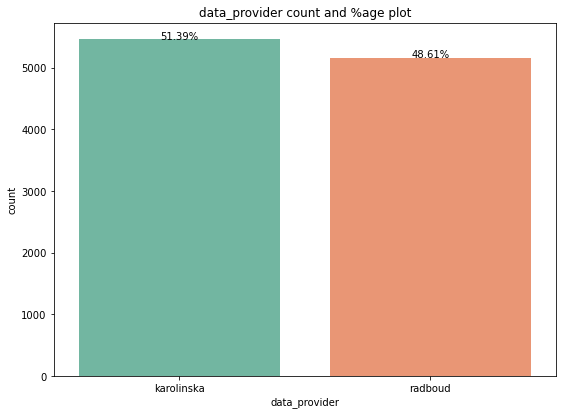

In [30]:
def plot_count(df, feature, title='', size=2):
    f, ax = plt.subplots(1,1, figsize=(4.5*size,3.25*size))
    total = float(len(df))
    sns.countplot(df[feature],order = df[feature].value_counts().index, palette='Set2')
    plt.title(title)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()
    
plot_count(df=train, feature='data_provider', title = 'data_provider count and %age plot')

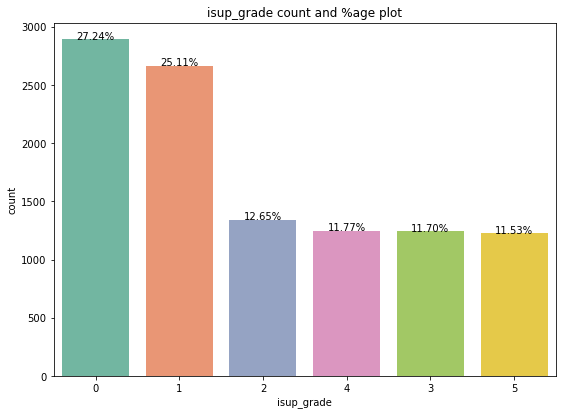

In [31]:
plot_count(df=train, feature='isup_grade', title = 'isup_grade count and %age plot')

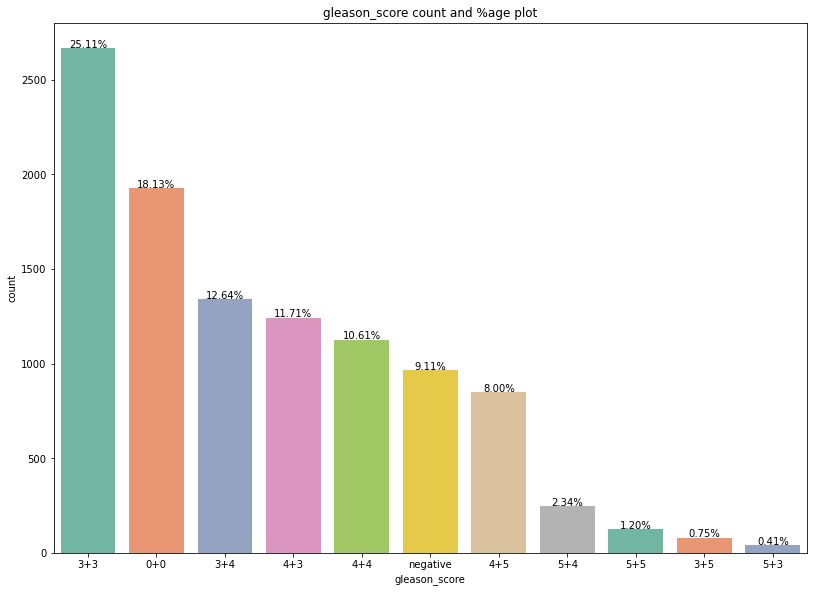

In [32]:
plot_count(df=train, feature='gleason_score', title = 'gleason_score count and %age plot', size=3)

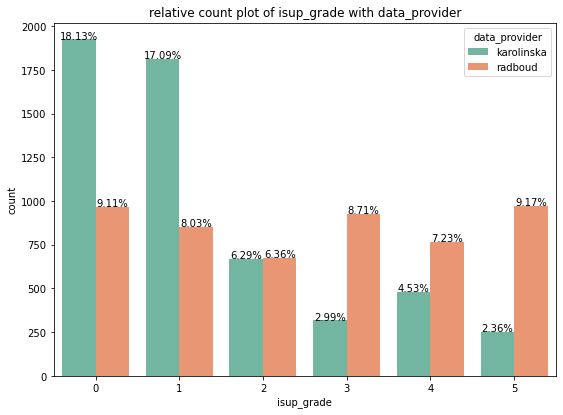

In [33]:
def plot_relative_distribution(df, feature, hue, title='', size=2):
    f, ax = plt.subplots(1,1, figsize=(4.5*size,3.25*size))
    total = float(len(df))
    sns.countplot(x=feature, hue=hue, data=df, palette='Set2')
    plt.title(title)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()
    
plot_relative_distribution(df=train, feature='isup_grade', hue='data_provider', title = 'relative count plot of isup_grade with data_provider', size=2)

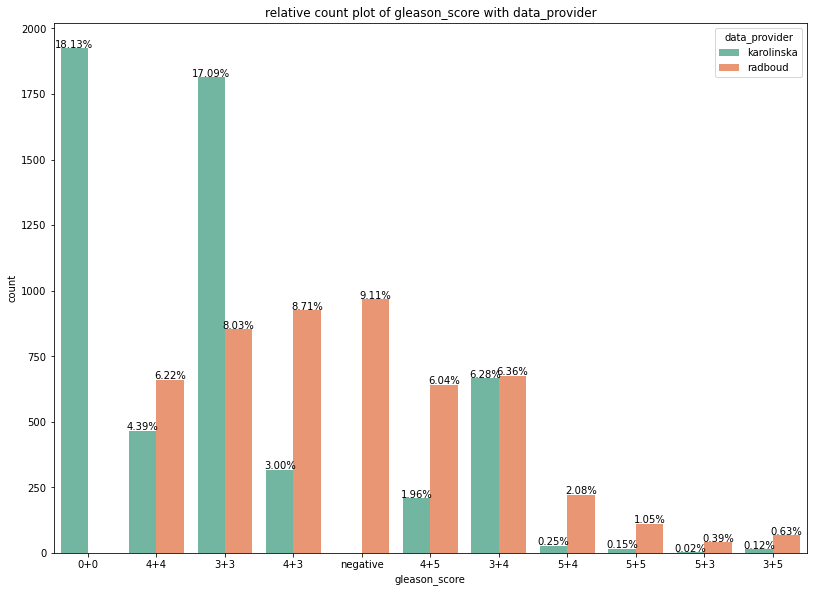

In [34]:
plot_relative_distribution(df=train, feature='gleason_score', hue='data_provider', title = 'relative count plot of gleason_score with data_provider', size=3)

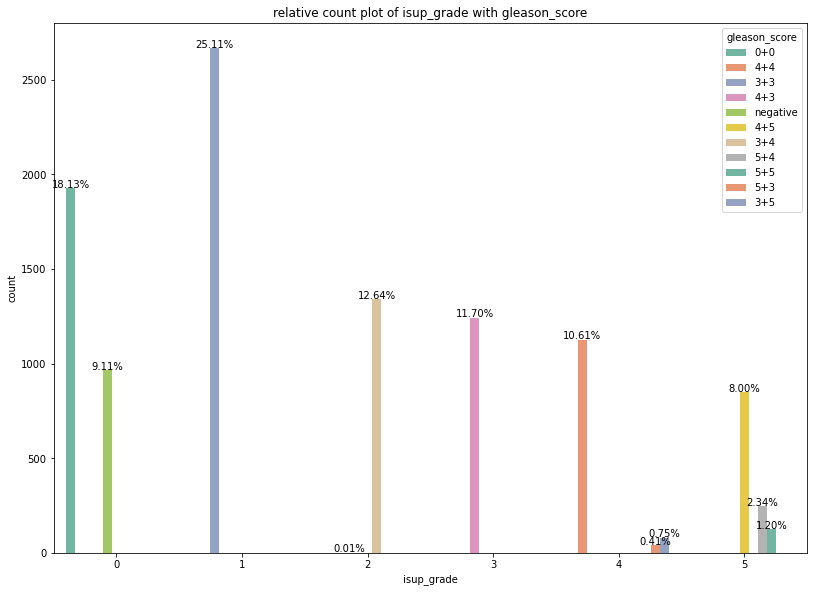

In [35]:
plot_relative_distribution(df=train, feature='isup_grade', hue='gleason_score', title = 'relative count plot of isup_grade with gleason_score', size=3)

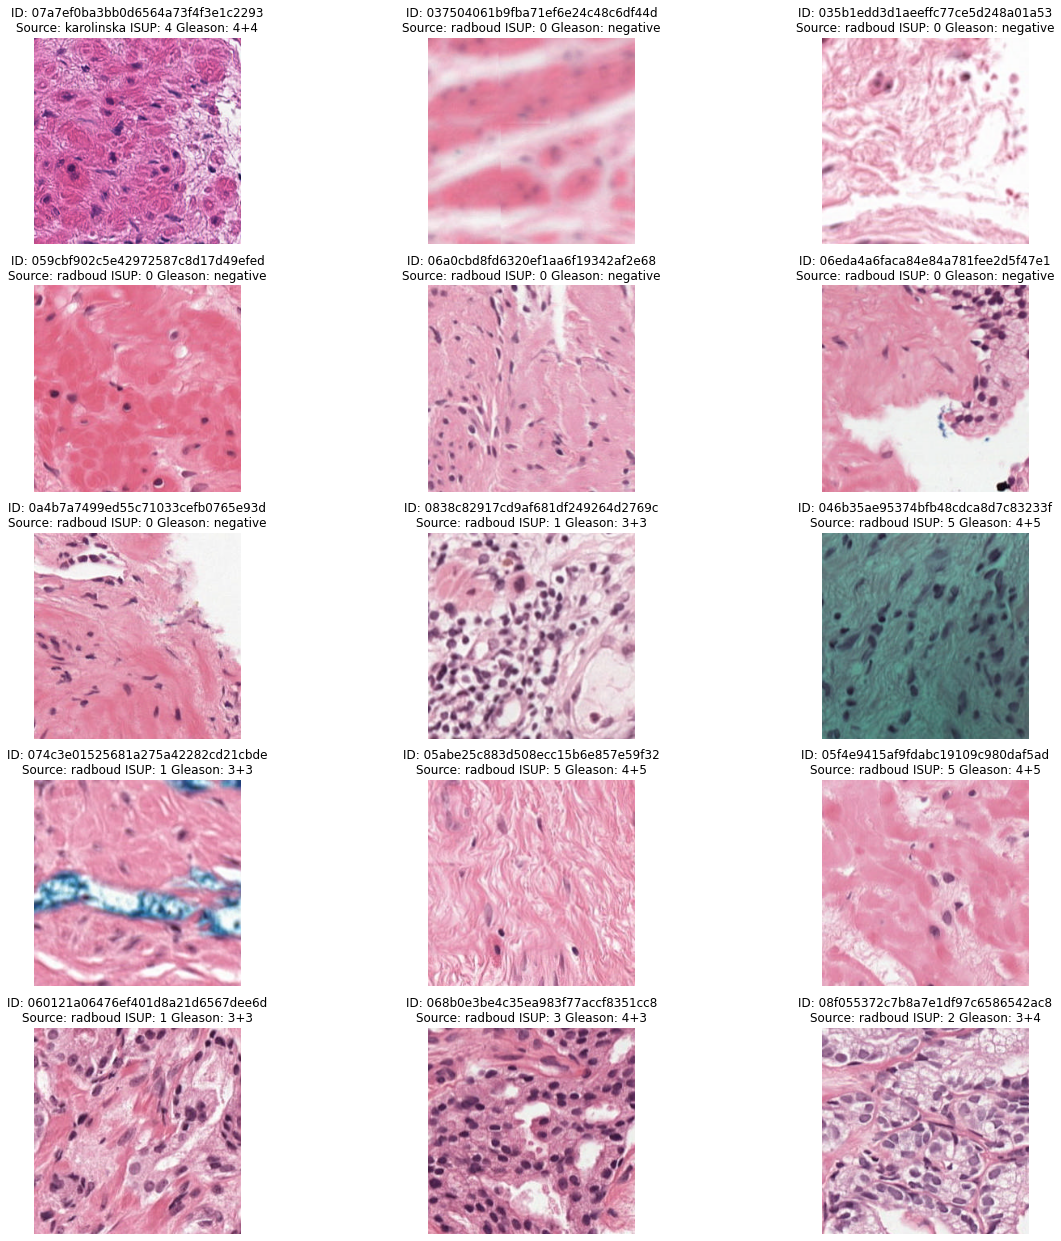

In [36]:
def display_images(slides): 
    f, ax = plt.subplots(5,3, figsize=(20, 22))
    for i, slide in enumerate(slides):
        image = openslide.OpenSlide(os.path.join(data_dir, f'{slide}.tiff'))
        spacing = 1 / (float(image.properties['tiff.XResolution']) / 10000)
        patch = image.read_region((1780,1950), 0, (256, 256))
        ax[i//3, i%3].imshow(patch) 
        image.close()       
        ax[i//3, i%3].axis('off')
        
        image_id = slide
        data_provider = train.loc[slide, 'data_provider']
        isup_grade = train.loc[slide, 'isup_grade']
        gleason_score = train.loc[slide, 'gleason_score']
        ax[i//3, i%3].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score}")

    plt.show() 
    
images = [
    '07a7ef0ba3bb0d6564a73f4f3e1c2293',
    '037504061b9fba71ef6e24c48c6df44d',
    '035b1edd3d1aeeffc77ce5d248a01a53',
    '059cbf902c5e42972587c8d17d49efed',
    '06a0cbd8fd6320ef1aa6f19342af2e68',
    '06eda4a6faca84e84a781fee2d5f47e1',
    '0a4b7a7499ed55c71033cefb0765e93d',
    '0838c82917cd9af681df249264d2769c',
    '046b35ae95374bfb48cdca8d7c83233f',
    '074c3e01525681a275a42282cd21cbde',
    '05abe25c883d508ecc15b6e857e59f32',
    '05f4e9415af9fdabc19109c980daf5ad',
    '060121a06476ef401d8a21d6567dee6d',
    '068b0e3be4c35ea983f77accf8351cc8',
    '08f055372c7b8a7e1df97c6586542ac8'
]

display_images(images)

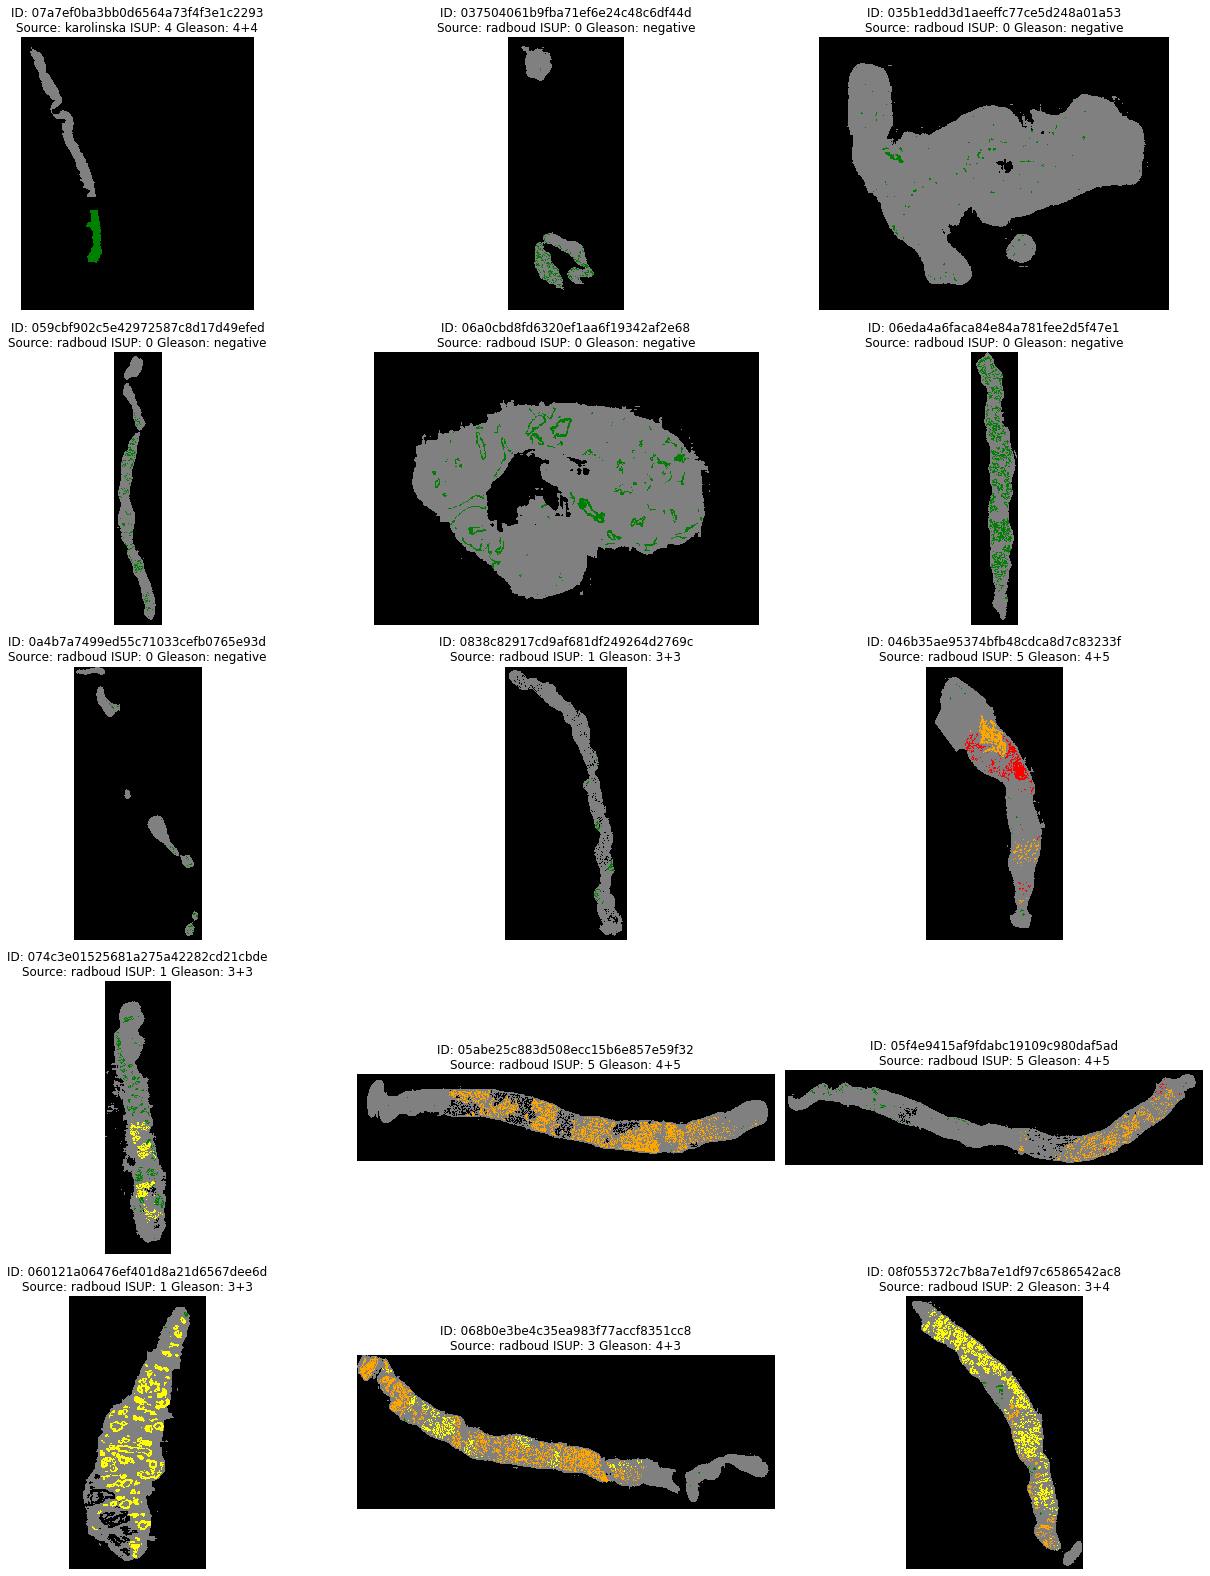

In [37]:
def display_masks(slides): 
    f, ax = plt.subplots(5,3, figsize=(18,22))
    for i, slide in enumerate(slides):
        
        mask = openslide.OpenSlide(os.path.join(mask_dir, f'{slide}_mask.tiff'))
        mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])
        cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])

        ax[i//3, i%3].imshow(np.asarray(mask_data)[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5) 
        mask.close()       
        ax[i//3, i%3].axis('off')
        
        image_id = slide
        data_provider = train.loc[slide, 'data_provider']
        isup_grade = train.loc[slide, 'isup_grade']
        gleason_score = train.loc[slide, 'gleason_score']
        ax[i//3, i%3].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score}")
        f.tight_layout()
        
    plt.show()
    
display_masks(images)

In [38]:
data_providers = ['karolinska', 'radboud']
train_df = pd.read_csv(f'{BASE_PATH}/train.csv')
masks = os.listdir(mask_dir)
masks_df = pd.Series(masks).to_frame()
masks_df.columns = ['mask_file_name']
masks_df['image_id'] = masks_df.mask_file_name.apply(lambda x: x.split('_')[0])
train_df = pd.merge(train_df, masks_df, on='image_id', how='outer')
del masks_df
print(f"There are {len(train_df[train_df.mask_file_name.isna()])} images without a mask.")

## removing items where image mask is null
train_df = train_df[~train_df.mask_file_name.isna()]

There are 100 images without a mask.


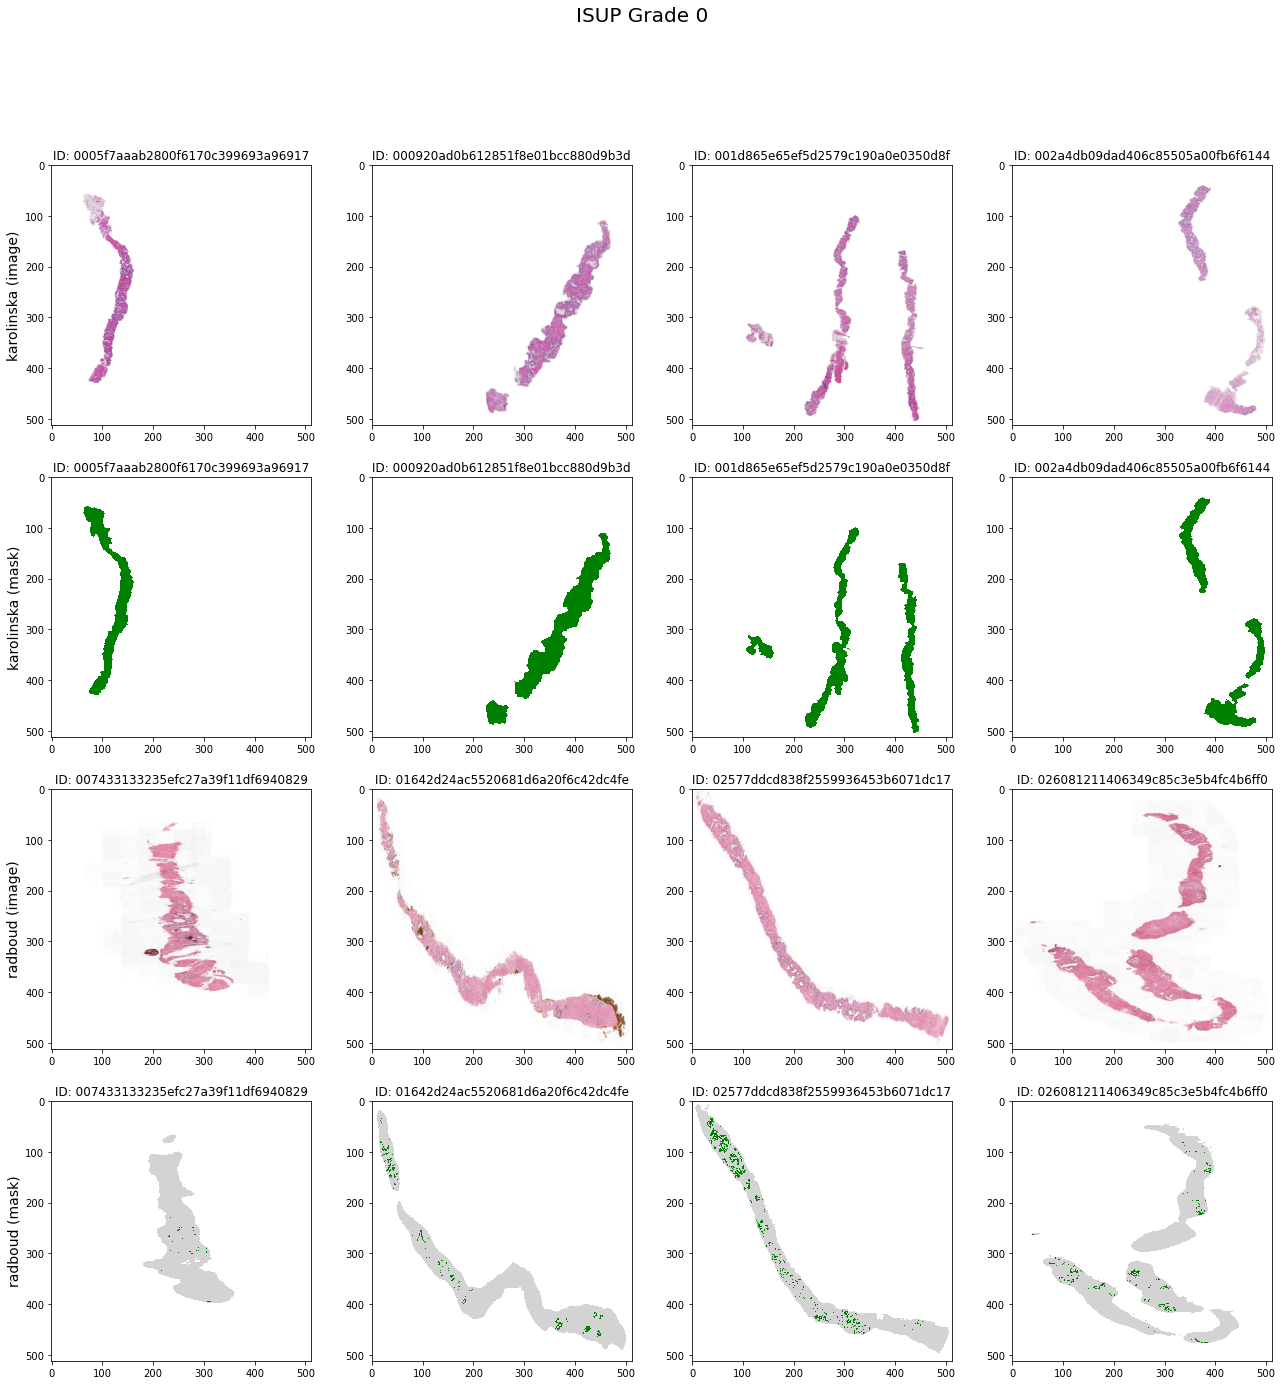

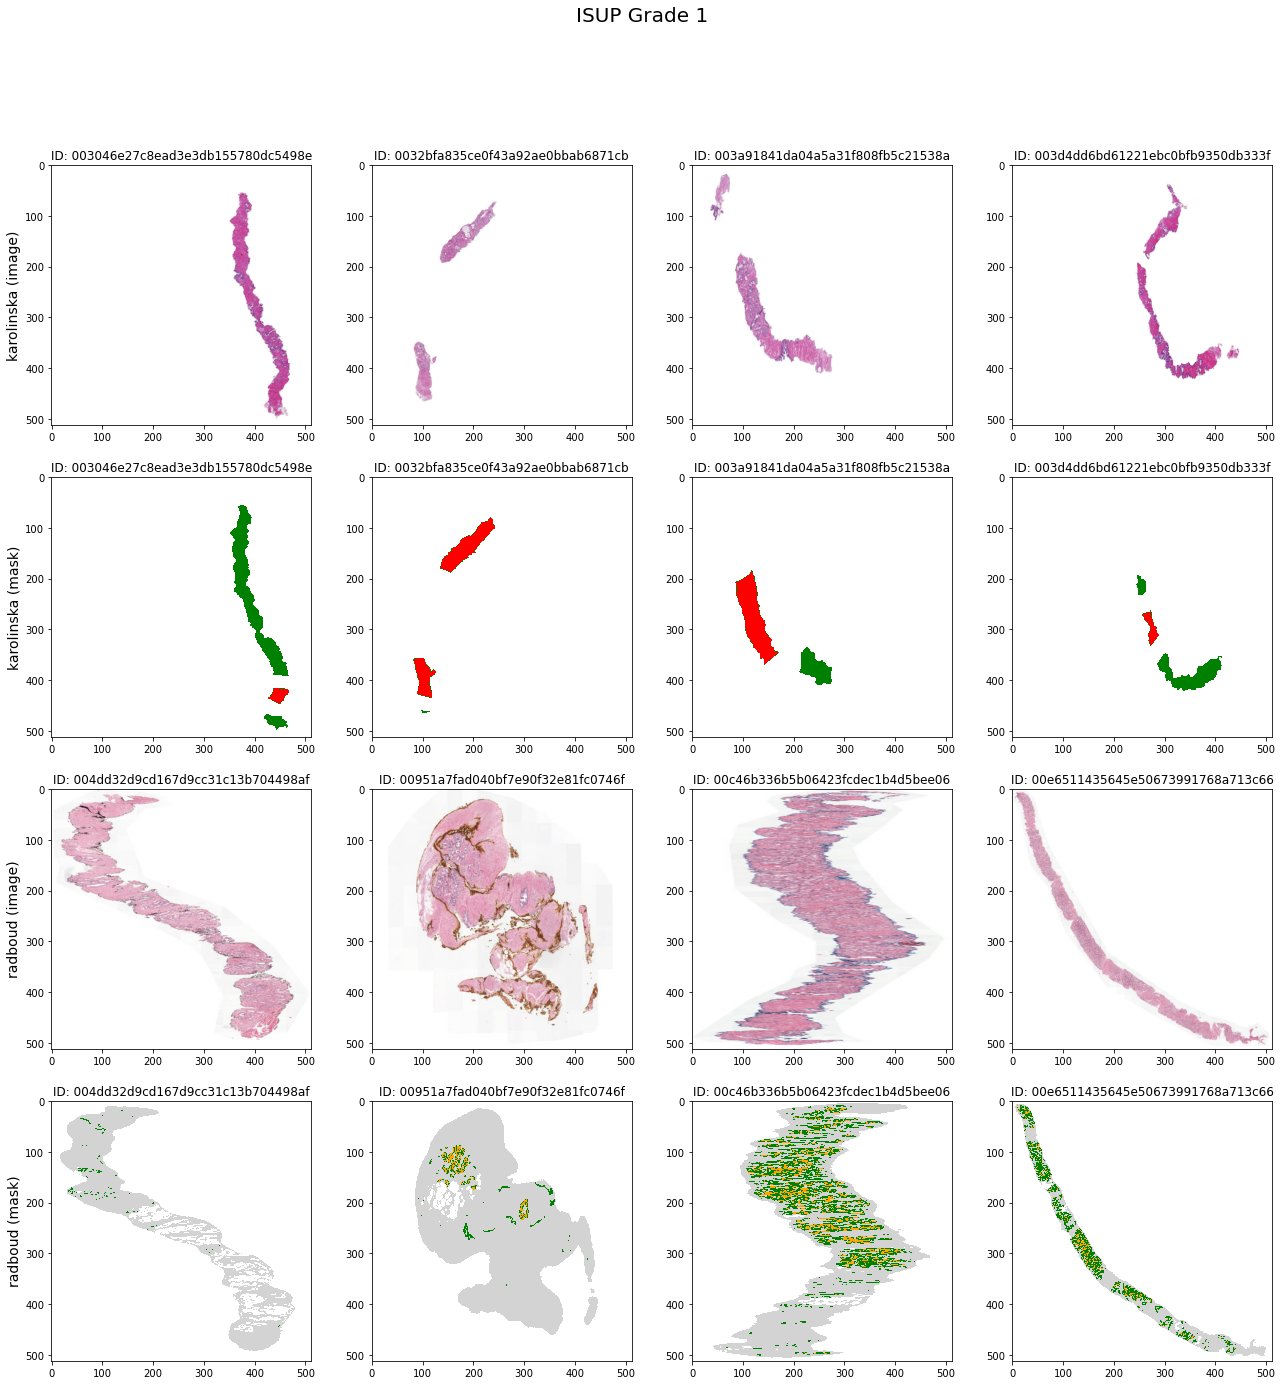

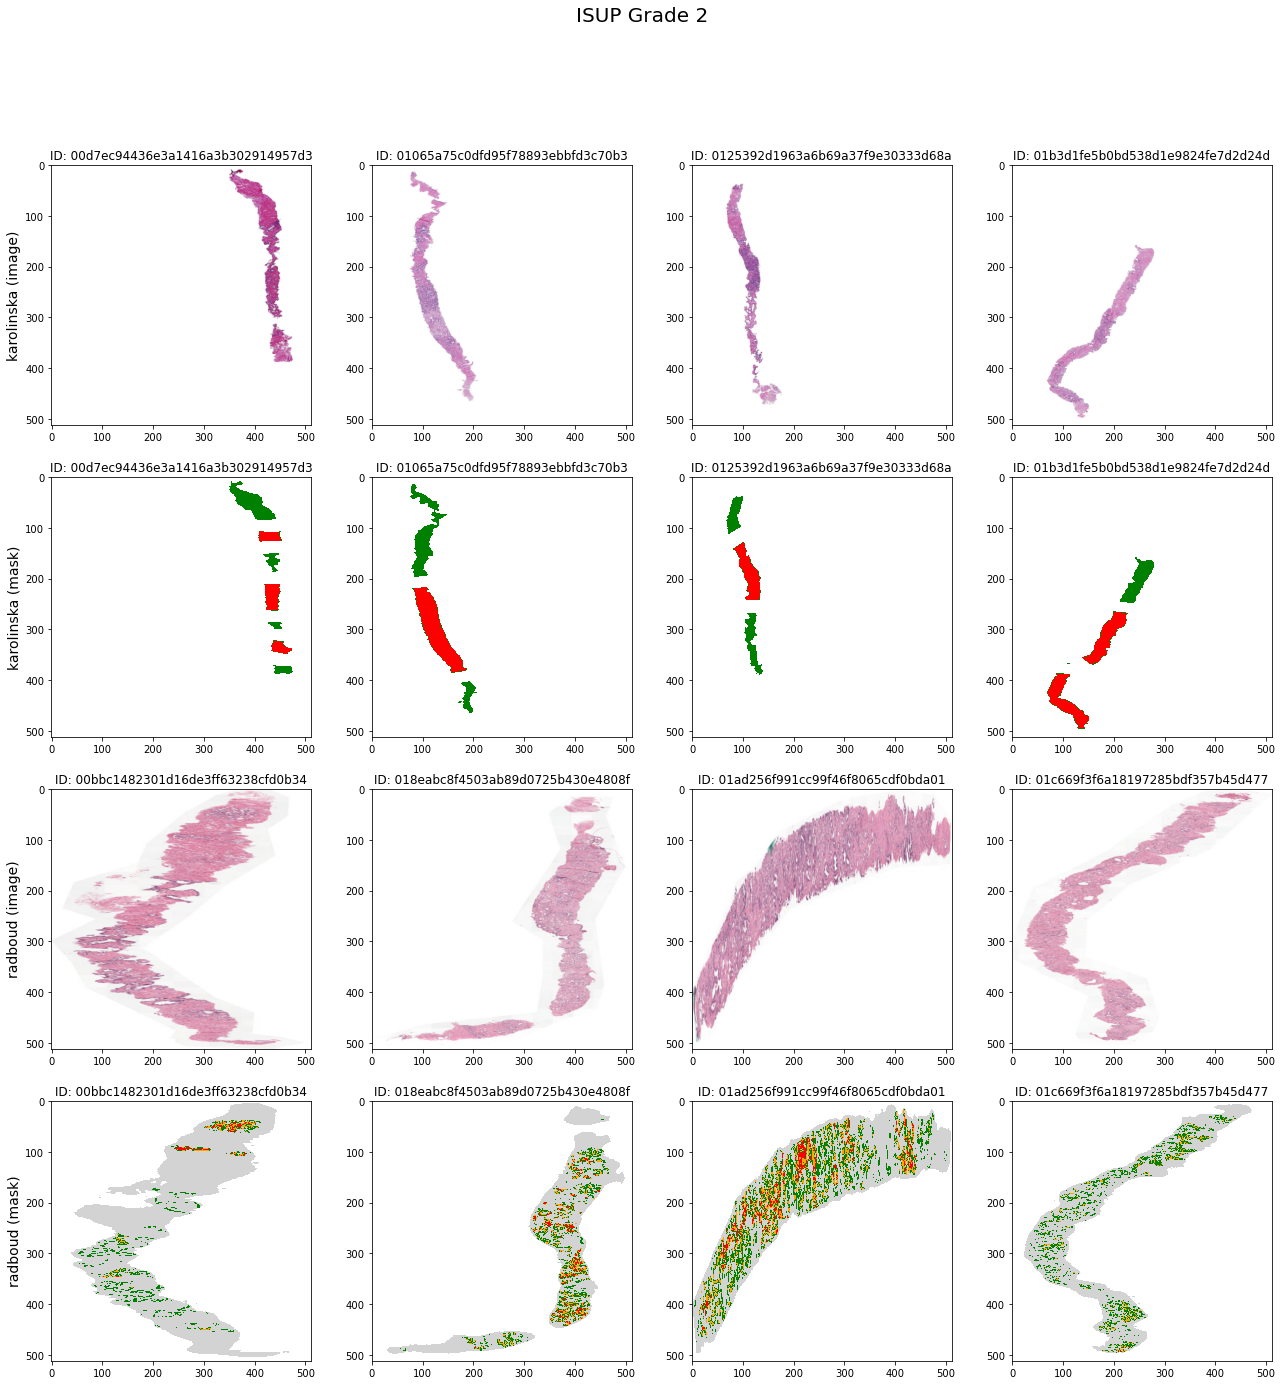

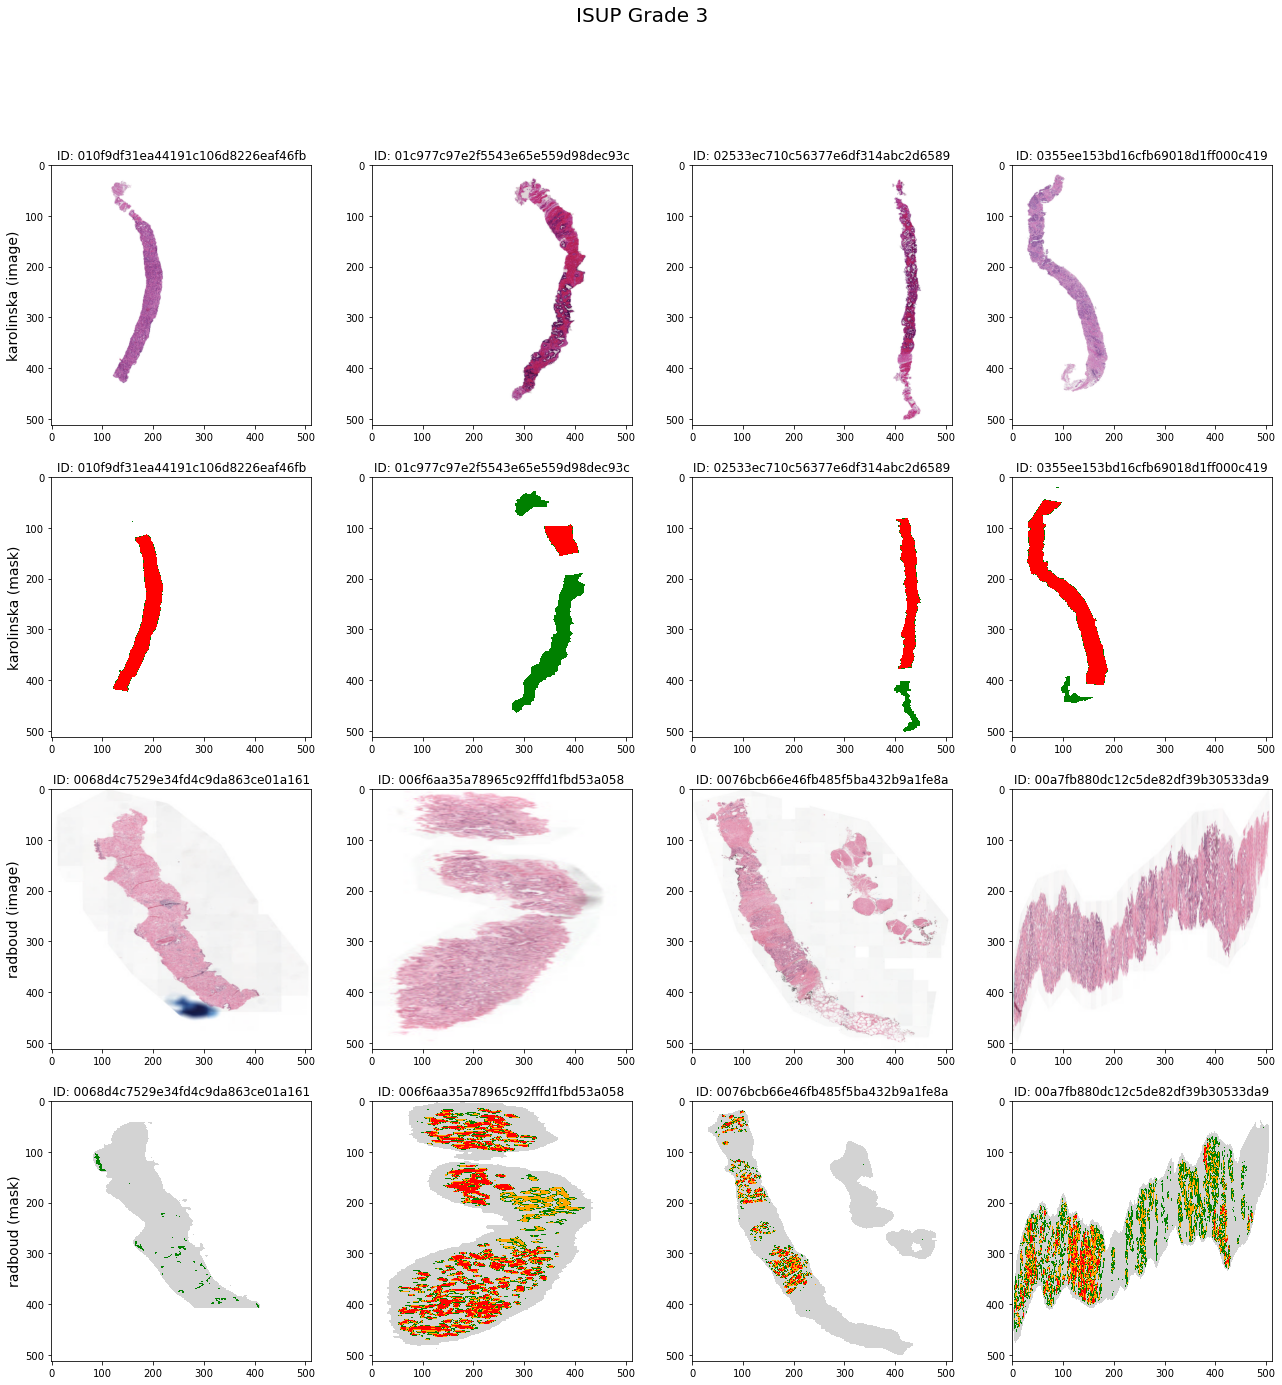

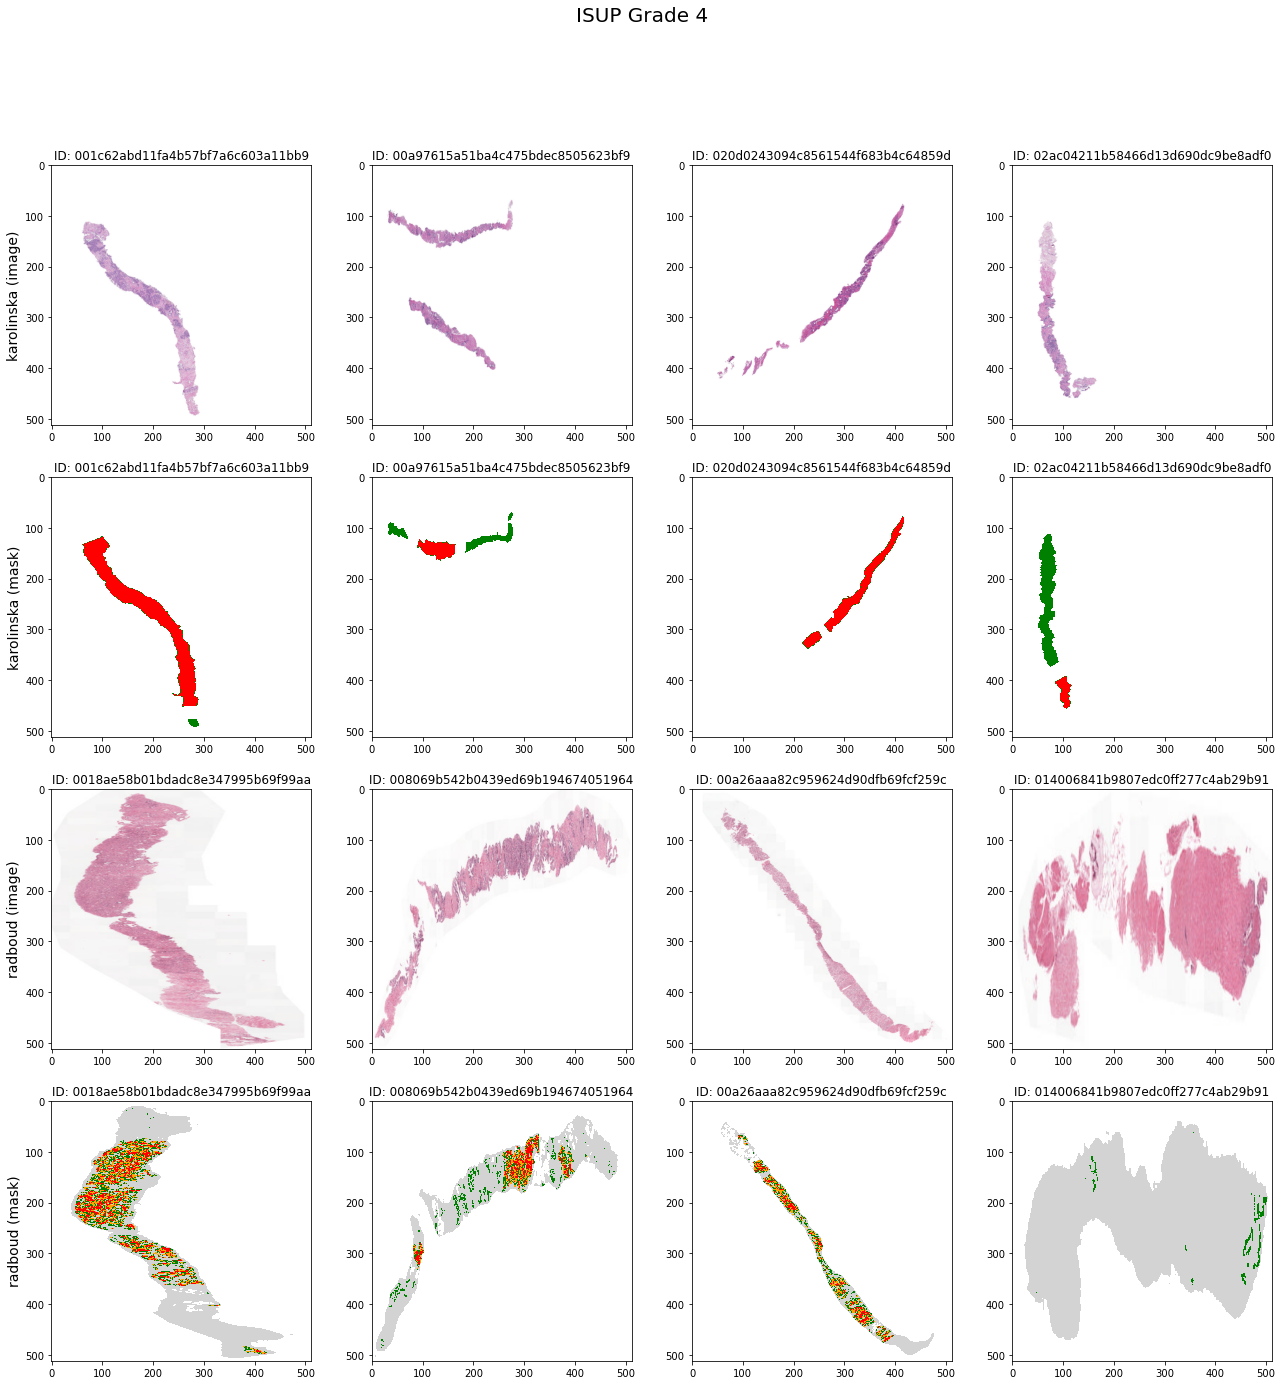

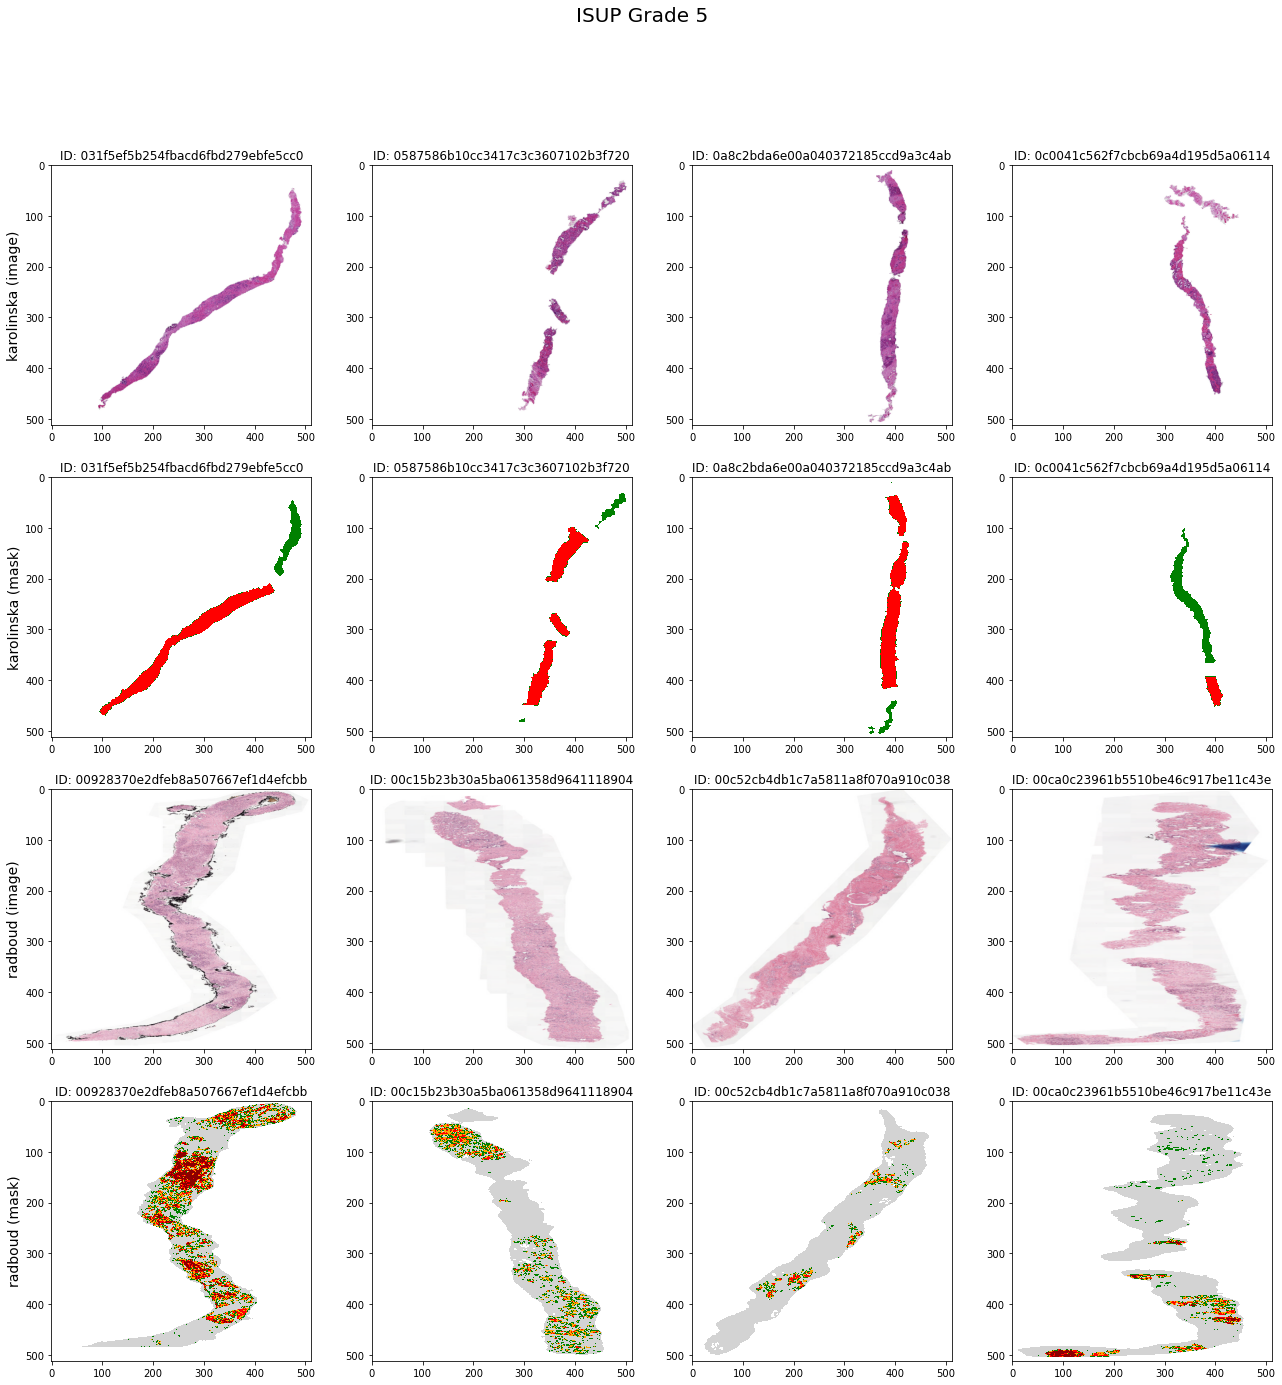

In [39]:
def load_and_resize_image(img_id):
    """
    Edited from https://www.kaggle.com/xhlulu/panda-resize-and-save-train-data
    """
    biopsy = skimage.io.MultiImage(os.path.join(data_dir, f'{img_id}.tiff'))
    return cv2.resize(biopsy[-1], (512, 512))

def load_and_resize_mask(img_id):
    """
    Edited from https://www.kaggle.com/xhlulu/panda-resize-and-save-train-data
    """
    biopsy = skimage.io.MultiImage(os.path.join(mask_dir, f'{img_id}_mask.tiff'))
    return cv2.resize(biopsy[-1], (512, 512))[:,:,0]

labels = []
for grade in range(train.isup_grade.nunique()):
    fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(22, 22))

    for i, row in enumerate(ax):
        idx = i//2
        temp = train_df[(train_df.isup_grade == grade) & (train_df.data_provider == data_providers[idx])].image_id.head(4).reset_index(drop=True)
        if i%2 < 1:
            labels.append(f'{data_providers[idx]} (image)')
            for j, col in enumerate(row):
                col.imshow(load_and_resize_image(temp[j]))
                col.set_title(f"ID: {temp[j]}")
                
        else:
            labels.append(f'{data_providers[idx]} (mask)')
            for j, col in enumerate(row):
                if data_providers[idx] == 'radboud':
                    col.imshow(load_and_resize_mask(temp[j]), 
                               cmap = matplotlib.colors.ListedColormap(['white', 'lightgrey', 'green', 'orange', 'red', 'darkred']), 
                               norm = matplotlib.colors.Normalize(vmin=0, vmax=5, clip=True))
                else:
                    col.imshow(load_and_resize_mask(temp[j]), 
                           cmap = matplotlib.colors.ListedColormap(['white', 'green', 'red']), 
                           norm = matplotlib.colors.Normalize(vmin=0, vmax=2, clip=True))
                    
                gleason_score = train.loc[temp[j], 'gleason_score']
                col.set_title(f"ID: {temp[j]}")
        
    for row, r in zip(ax[:,0], labels):
        row.set_ylabel(r, rotation=90, size='large', fontsize=14)

    plt.suptitle(f'ISUP Grade {grade}', fontsize=20)
    plt.show()

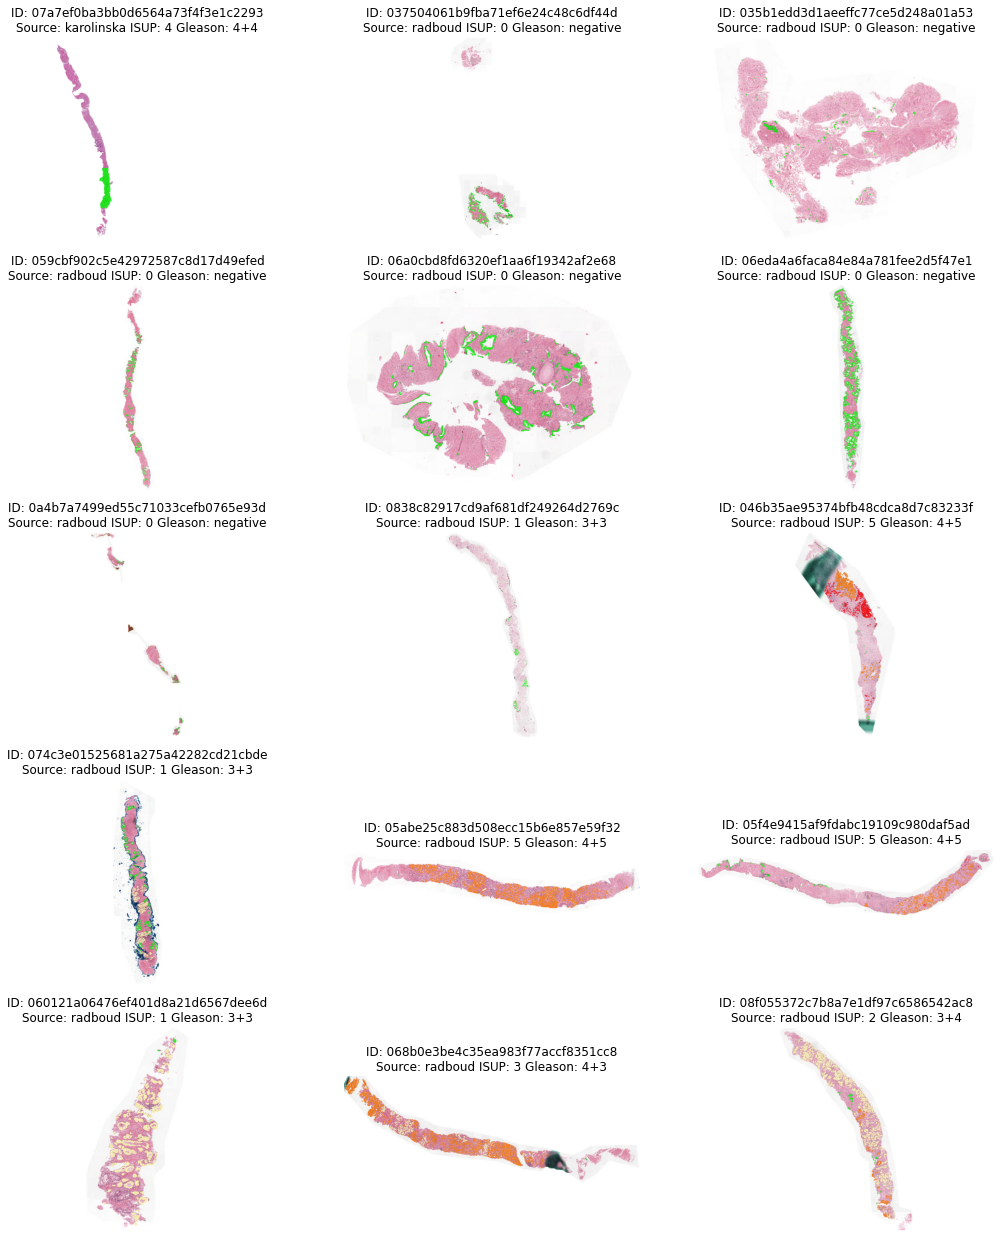

In [40]:
def overlay_mask_on_slide(images, center='radboud', alpha=0.8, max_size=(800, 800)):
    """Show a mask overlayed on a slide."""
    f, ax = plt.subplots(5,3, figsize=(18,22))
    
    
    for i, image_id in enumerate(images):
        slide = openslide.OpenSlide(os.path.join(data_dir, f'{image_id}.tiff'))
        mask = openslide.OpenSlide(os.path.join(mask_dir, f'{image_id}_mask.tiff'))
        slide_data = slide.read_region((0,0), slide.level_count - 1, slide.level_dimensions[-1])
        mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])
        mask_data = mask_data.split()[0]
        
        
        # Create alpha mask
        alpha_int = int(round(255*alpha))
        if center == 'radboud':
            alpha_content = np.less(mask_data.split()[0], 2).astype('uint8') * alpha_int + (255 - alpha_int)
        elif center == 'karolinska':
            alpha_content = np.less(mask_data.split()[0], 1).astype('uint8') * alpha_int + (255 - alpha_int)

        alpha_content = PIL.Image.fromarray(alpha_content)
        preview_palette = np.zeros(shape=768, dtype=int)

        if center == 'radboud':
            # Mapping: {0: background, 1: stroma, 2: benign epithelium, 3: Gleason 3, 4: Gleason 4, 5: Gleason 5}
            preview_palette[0:18] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 0, 1, 0, 1, 1, 0.7, 1, 0.5, 0, 1, 0, 0]) * 255).astype(int)
        elif center == 'karolinska':
            # Mapping: {0: background, 1: benign, 2: cancer}
            preview_palette[0:9] = (np.array([0, 0, 0, 0, 1, 0, 1, 0, 0]) * 255).astype(int)

        mask_data.putpalette(data=preview_palette.tolist())
        mask_rgb = mask_data.convert(mode='RGB')
        overlayed_image = PIL.Image.composite(image1=slide_data, image2=mask_rgb, mask=alpha_content)
        overlayed_image.thumbnail(size=max_size, resample=0)

        
        ax[i//3, i%3].imshow(overlayed_image) 
        slide.close()
        mask.close()       
        ax[i//3, i%3].axis('off')
        
        data_provider = train.loc[image_id, 'data_provider']
        isup_grade = train.loc[image_id, 'isup_grade']
        gleason_score = train.loc[image_id, 'gleason_score']
        ax[i//3, i%3].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score}")
        
overlay_mask_on_slide(images)

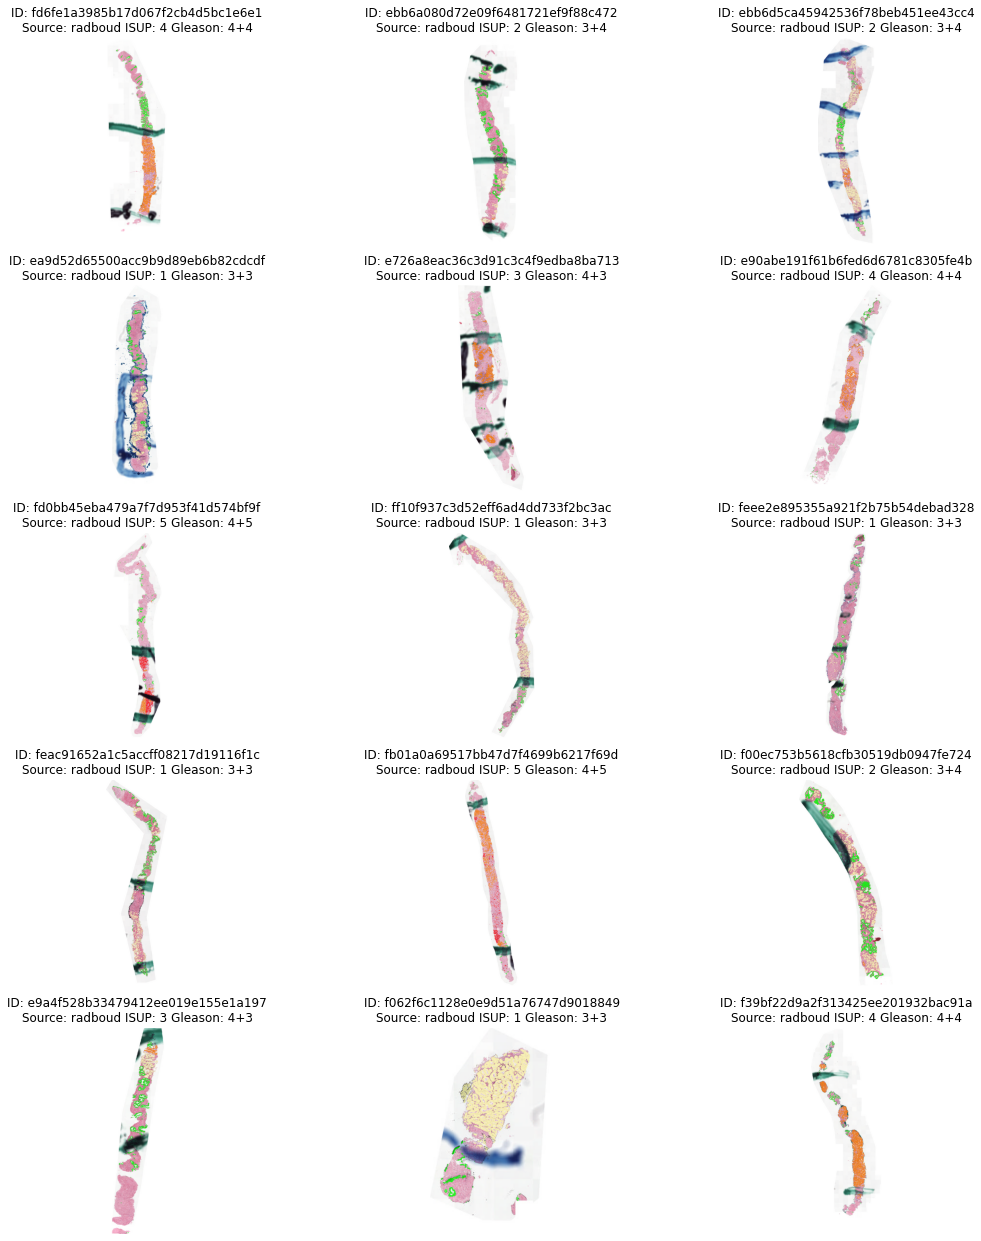

In [41]:
pen_marked_images = [
    'fd6fe1a3985b17d067f2cb4d5bc1e6e1',
    'ebb6a080d72e09f6481721ef9f88c472',
    'ebb6d5ca45942536f78beb451ee43cc4',
    'ea9d52d65500acc9b9d89eb6b82cdcdf',
    'e726a8eac36c3d91c3c4f9edba8ba713',
    'e90abe191f61b6fed6d6781c8305fe4b',
    'fd0bb45eba479a7f7d953f41d574bf9f',
    'ff10f937c3d52eff6ad4dd733f2bc3ac',
    'feee2e895355a921f2b75b54debad328',
    'feac91652a1c5accff08217d19116f1c',
    'fb01a0a69517bb47d7f4699b6217f69d',
    'f00ec753b5618cfb30519db0947fe724',
    'e9a4f528b33479412ee019e155e1a197',
    'f062f6c1128e0e9d51a76747d9018849',
    'f39bf22d9a2f313425ee201932bac91a',
]

overlay_mask_on_slide(pen_marked_images)